Device: cuda
Dataset path: /kaggle/input/python-dataset/Python_LargeClassSmell_Dataset.csv
Loaded dataset with 1000 rows and columns: ['loc', 'lloc', 'scloc', 'comments', 'single_comments', 'multi_comments', 'blanks', 'h1', 'h2', 'n1', 'n2', 'vocabulary', 'length', 'calculated_length', 'volume', 'difficulty', 'effort', 'time', 'bugs', 'LargeClass']
Features shape: (1000, 19), Labels shape: (1000,)
Overall class distribution: [800 200]
Train samples: 800, Test samples: 200
Train class distribution: [640 160]
Test class distribution : [160  40]
Epoch 1/1000 - Loss: 0.5652 - F1: 0.4074 - Acc: 0.8400 - Precision: 0.7857 - Recall: 0.2750 - MCC: 0.4017
  Saved new best model (f1 improved).
Epoch 2/1000 - Loss: 0.4044 - F1: 0.4912 - Acc: 0.8550 - Precision: 0.8235 - Recall: 0.3500 - MCC: 0.4751
  Saved new best model (f1 improved).
Epoch 3/1000 - Loss: 0.3653 - F1: 0.5263 - Acc: 0.8650 - Precision: 0.8824 - Recall: 0.3750 - MCC: 0.5199
  Saved new best model (f1 improved).
Epoch 4/1000 - Loss

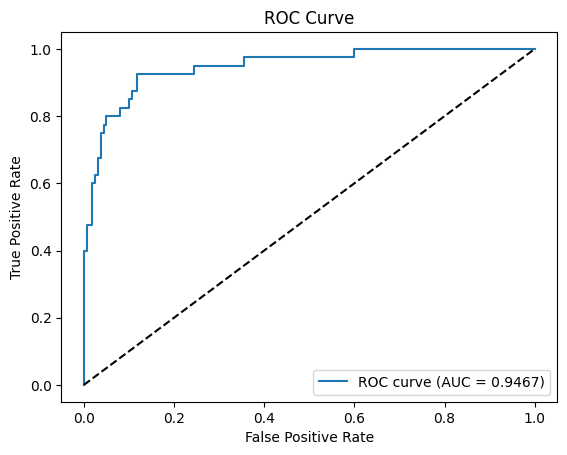

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Metrics-only LargeClass smell detection (single-file runnable script)

- Expects: /mnt/data/Python_LargeClassSmell_Dataset.csv
- Uses "LargeClass" column as target (0/1)
- All other columns are treated as numeric features (metrics)
"""

import os
import random
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.metrics import (
    precision_recall_fscore_support,
    matthews_corrcoef,
    confusion_matrix,
    accuracy_score,
    classification_report,
    roc_auc_score,
    roc_curve
)

# ---------------------------
# Config
# ---------------------------
SEED = 42
BATCH_SIZE = 64
EPOCHS = 1000  # Increased
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DATA_PATH = "/kaggle/input/python-dataset/Python_LargeClassSmell_Dataset.csv"  # update if necessary
MODEL_OUT = "/kaggle/working/metrics_model_best_f1.pth"

# If True: run Stratified 5-Fold CV instead of single train/test split
DO_CV = False

# Reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print(f"Device: {DEVICE}")
print(f"Dataset path: {DATA_PATH}")

# ---------------------------
# Data loader / preprocessing
# ---------------------------
class PythonMetricsLoader:
    def __init__(self, data_path):
        self.data_path = Path(data_path)
        self.df = None

    def load(self):
        if not self.data_path.exists():
            raise FileNotFoundError(f"Dataset not found: {self.data_path}")
        self.df = pd.read_csv(self.data_path)
        return self.df

    def preprocess(self):
        if self.df is None:
            self.load()

        if "LargeClass" not in self.df.columns:
            raise ValueError("Dataset must contain 'LargeClass' column as target (0/1).")

        # Features: all columns except LargeClass
        X = self.df.drop(columns=["LargeClass"]).values.astype(float)
        y = self.df["LargeClass"].astype(int).values

        # Impute missing values and scale
        imputer = KNNImputer(n_neighbors=3)
        scaler = StandardScaler()
        X = imputer.fit_transform(X)
        X = scaler.fit_transform(X)

        return X, y

# ---------------------------
# Dataset class
# ---------------------------
class PythonMetricsDataset(Dataset):
    def __init__(self, metrics, labels):
        self.metrics = torch.tensor(metrics, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.metrics[idx], self.labels[idx]

# ---------------------------
# Model: metrics-only DNN
# ---------------------------
class MetricsClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims=(128, 64, 32), dropout=0.3, num_classes=2):
        super().__init__()
        layers = []
        prev = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev, h))
            layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev = h
        layers.append(nn.Linear(prev, num_classes))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# ---------------------------
# Trainer
# ---------------------------
class Trainer:
    def __init__(self, model, device=DEVICE, lr=LEARNING_RATE):
        self.model = model.to(device)
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr)

    def train_epoch(self, loader):
        self.model.train()
        total_loss = 0.0
        for metrics, labels in loader:
            metrics = metrics.to(self.device)
            labels = labels.to(self.device)
            self.optimizer.zero_grad()
            logits = self.model(metrics)
            loss = self.criterion(logits, labels)
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item()
        return total_loss / len(loader)

    def evaluate(self, loader):
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        with torch.no_grad():
            for metrics, labels in loader:
                metrics = metrics.to(self.device)
                labels = labels.to(self.device)
                logits = self.model(metrics)
                probs = F.softmax(logits, dim=1)
                preds = torch.argmax(probs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs[:, 1].cpu().numpy())

        all_labels = np.array(all_labels)
        all_preds = np.array(all_preds)
        all_probs = np.array(all_probs)

        accuracy = accuracy_score(all_labels, all_preds)
        precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average="binary", zero_division=0)
        mcc = matthews_corrcoef(all_labels, all_preds)
        cm = confusion_matrix(all_labels, all_preds)
        cls_report = classification_report(all_labels, all_preds, digits=4)
        try:
            roc_auc = roc_auc_score(all_labels, all_probs)
        except ValueError:
            roc_auc = float('nan')

        return {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "mcc": mcc,
            "confusion_matrix": cm,
            "classification_report": cls_report,
            "roc_auc": roc_auc,
            "probs": all_probs,
            "labels": all_labels
        }

# ---------------------------
# Utilities
# ---------------------------
def print_metrics_dict(metrics):
    for k, v in metrics.items():
        if k == "confusion_matrix":
            print(f"{k}:\n{v}")
        elif k == "classification_report":
            print(f"{k}:\n{v}")
        else:
            print(f"{k}: {v:.4f}")

# ---------------------------
# Main: single train/test experiment
# ---------------------------
def run_single_experiment(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
    print(f"Train samples: {len(y_train)}, Test samples: {len(y_test)}")
    print("Train class distribution:", np.bincount(y_train))
    print("Test class distribution :", np.bincount(y_test))

    train_ds = PythonMetricsDataset(X_train, y_train)
    test_ds = PythonMetricsDataset(X_test, y_test)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

    model = MetricsClassifier(input_dim=X.shape[1])
    trainer = Trainer(model)

    best_f1 = -1.0
    for epoch in range(1, EPOCHS + 1):
        loss = trainer.train_epoch(train_loader)
        metrics = trainer.evaluate(test_loader)
        print(f"Epoch {epoch}/{EPOCHS} - Loss: {loss:.4f} - F1: {metrics['f1']:.4f} - Acc: {metrics['accuracy']:.4f} - Precision: {metrics['precision']:.4f} - Recall: {metrics['recall']:.4f} - MCC: {metrics['mcc']:.4f}")
        if metrics['f1'] > best_f1:
            best_f1 = metrics['f1']
            torch.save(model.state_dict(), MODEL_OUT)
            print("  Saved new best model (f1 improved).")

    # Load best model
    model.load_state_dict(torch.load(MODEL_OUT, map_location=DEVICE))
    print("Loaded best model from", MODEL_OUT)

    # Final evaluation
    final_metrics = trainer.evaluate(test_loader)
    print("\nFinal test metrics:")
    print(f"Accuracy: {final_metrics['accuracy']:.4f}")
    print(f"Precision: {final_metrics['precision']:.4f}")
    print(f"Recall: {final_metrics['recall']:.4f}")
    print(f"F1-Score: {final_metrics['f1']:.4f}")
    print(f"MCC: {final_metrics['mcc']:.4f}")
    print(f"ROC-AUC: {final_metrics['roc_auc']:.4f}")
    print("Confusion Matrix:\n", final_metrics['confusion_matrix'])
    print("Classification Report:\n", final_metrics['classification_report'])

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(final_metrics['labels'], final_metrics['probs'])
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {final_metrics['roc_auc']:.4f})")
    plt.plot([0,1], [0,1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return final_metrics

# ---------------------------
# Main entrypoint
# ---------------------------
def main():
    loader = PythonMetricsLoader(DATA_PATH)
    df = loader.load()
    print(f"Loaded dataset with {len(df)} rows and columns: {df.columns.tolist()}")

    X, y = loader.preprocess()
    print(f"Features shape: {X.shape}, Labels shape: {y.shape}")
    print("Overall class distribution:", np.bincount(y))

    if DO_CV:
        # You can implement CV with metrics if desired
        pass
    else:
        run_single_experiment(X, y)

if __name__ == "__main__":
    main()


Loaded dataset with 894 rows and columns: ['loc', 'lloc', 'scloc', 'comments', 'single_comments', 'multi_comments', 'blanks', 'h1', 'h2', 'n1', 'n2', 'vocabulary', 'length', 'calculated_length', 'volume', 'difficulty', 'effort', 'time', 'bugs', 'Experince Based']
Features shape: (894, 19), Labels shape: (894,)
Overall class distribution: [685 209]
Epoch 50/1000 - Loss: 0.3513 - Acc: 0.8380 - Prec: 0.7600 - Rec: 0.4524 - F1: 0.5672 - MCC: 0.4995 - ROC-AUC: 0.9301
Epoch 100/1000 - Loss: 0.2752 - Acc: 0.8101 - Prec: 0.8333 - Rec: 0.2381 - F1: 0.3704 - MCC: 0.3787 - ROC-AUC: 0.9559
Epoch 150/1000 - Loss: 0.3101 - Acc: 0.9274 - Prec: 0.7736 - Rec: 0.9762 - F1: 0.8632 - MCC: 0.8248 - ROC-AUC: 0.9750
Epoch 200/1000 - Loss: 0.2120 - Acc: 0.9330 - Prec: 0.7885 - Rec: 0.9762 - F1: 0.8723 - MCC: 0.8363 - ROC-AUC: 0.9765
Epoch 250/1000 - Loss: 0.1779 - Acc: 0.9385 - Prec: 0.8298 - Rec: 0.9286 - F1: 0.8764 - MCC: 0.8380 - ROC-AUC: 0.9743
Epoch 300/1000 - Loss: 0.2555 - Acc: 0.9497 - Prec: 0.8511 - 

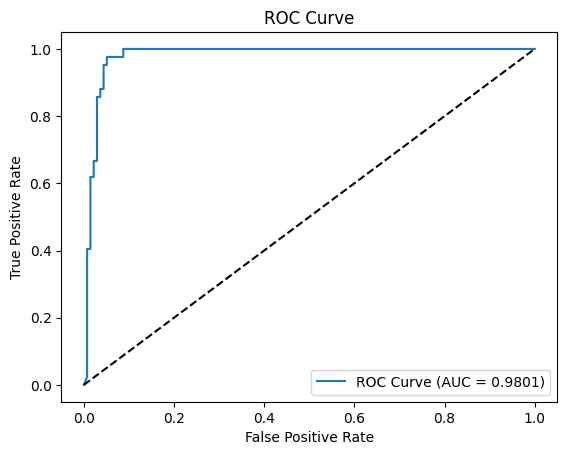

Best model saved to metrics_model_best_f1.pth

=== Final Evaluation Metrics ===
accuracy: 0.9497
precision: 0.8367
recall: 0.9762
f1: 0.9011
mcc: 0.8723
confusion_matrix:
[[129   8]
 [  1  41]]
classification_report:
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.97       137
         1.0       0.84      0.98      0.90        42

    accuracy                           0.95       179
   macro avg       0.91      0.96      0.93       179
weighted avg       0.96      0.95      0.95       179

roc_auc: 0.9801


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, confusion_matrix, classification_report,
    roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import random

# ---------------------------
# Config
# ---------------------------
SEED = 42
BATCH_SIZE = 64
EPOCHS = 1000
LEARNING_RATE = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

DATA_PATH = "/kaggle/input/python-dataset/Python_LongMethodSmell_Dataset.csv"
MODEL_OUT = "metrics_model_best_f1.pth"
DO_CV = False

# ---------------------------
# Reproducibility
# ---------------------------
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

# ---------------------------
# Dataset Loader
# ---------------------------
class MetricsDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class DataLoaderWrapper:
    def __init__(self, path):
        self.path = path
        self.df = None

    def load(self):
        self.df = pd.read_csv(self.path)
        self.df.columns = self.df.columns.str.strip()
        return self.df

    def preprocess(self):
        if self.df is None:
            self.load()

        if "Experince Based" not in self.df.columns:
            raise ValueError(f"Target column not found. Available: {self.df.columns.tolist()}")

        X = self.df.drop(columns=["Experince Based"]).values.astype(float)
        y = self.df["Experince Based"].astype(int).values
        return X, y

# ---------------------------
# Neural Net Model
# ---------------------------
class MetricsModel(nn.Module):
    def __init__(self, input_dim):
        super(MetricsModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# ---------------------------
# Training
# ---------------------------
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS):
    best_f1 = 0
    best_state = None

    for epoch in range(1, epochs + 1):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(DEVICE), y_val.to(DEVICE).unsqueeze(1)
                preds = model(X_val)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(y_val.cpu().numpy())

        val_preds_bin = (np.array(val_preds) > 0.5).astype(int)

        acc = accuracy_score(val_targets, val_preds_bin)
        prec = precision_score(val_targets, val_preds_bin, zero_division=0)
        rec = recall_score(val_targets, val_preds_bin, zero_division=0)
        f1 = f1_score(val_targets, val_preds_bin, zero_division=0)
        mcc = matthews_corrcoef(val_targets, val_preds_bin)
        cm = confusion_matrix(val_targets, val_preds_bin)
        class_report = classification_report(val_targets, val_preds_bin, zero_division=0)
        try:
            roc_auc = roc_auc_score(val_targets, val_preds)
        except:
            roc_auc = float("nan")

        if f1 > best_f1:
            best_f1 = f1
            best_state = model.state_dict()

        if epoch % 50 == 0 or epoch == epochs:
            print(
                f"Epoch {epoch}/{epochs} - Loss: {np.mean(train_losses):.4f} - "
                f"Acc: {acc:.4f} - Prec: {prec:.4f} - Rec: {rec:.4f} - F1: {f1:.4f} - MCC: {mcc:.4f} - ROC-AUC: {roc_auc:.4f}"
            )

    model.load_state_dict(best_state)

    # Final evaluation
    final_preds, final_targets = [], []
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(DEVICE), y_val.to(DEVICE).unsqueeze(1)
            preds = model(X_val)
            final_preds.extend(preds.cpu().numpy())
            final_targets.extend(y_val.cpu().numpy())

    final_preds_bin = (np.array(final_preds) > 0.5).astype(int)
    final_metrics = {
        "accuracy": accuracy_score(final_targets, final_preds_bin),
        "precision": precision_score(final_targets, final_preds_bin, zero_division=0),
        "recall": recall_score(final_targets, final_preds_bin, zero_division=0),
        "f1": f1_score(final_targets, final_preds_bin, zero_division=0),
        "mcc": matthews_corrcoef(final_targets, final_preds_bin),
        "confusion_matrix": confusion_matrix(final_targets, final_preds_bin),
        "classification_report": classification_report(final_targets, final_preds_bin, zero_division=0),
    }
    try:
        final_metrics["roc_auc"] = roc_auc_score(final_targets, final_preds)
        fpr, tpr, _ = roc_curve(final_targets, final_preds)
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {final_metrics['roc_auc']:.4f})")
        plt.plot([0, 1], [0, 1], "k--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.show()
    except:
        final_metrics["roc_auc"] = float("nan")

    return model, final_metrics

# ---------------------------
# Main
# ---------------------------
def main():
    loader = DataLoaderWrapper(DATA_PATH)
    df = loader.load()
    print(f"Loaded dataset with {len(df)} rows and columns: {df.columns.tolist()}")

    X, y = loader.preprocess()
    print(f"Features shape: {X.shape}, Labels shape: {y.shape}")
    print("Overall class distribution:", np.bincount(y))

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

    train_dataset = MetricsDataset(X_train, y_train)
    val_dataset = MetricsDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

    model = MetricsModel(input_dim=X.shape[1]).to(DEVICE)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    model, final_metrics = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS)

    torch.save(model.state_dict(), MODEL_OUT)
    print(f"Best model saved to {MODEL_OUT}")

    print("\n=== Final Evaluation Metrics ===")
    for k, v in final_metrics.items():
        if k in ["confusion_matrix", "classification_report"]:
            print(f"{k}:\n{v}")
        else:
            print(f"{k}: {v:.4f}")


if __name__ == "__main__":
    main()
